In [1]:
#MODULE NAME
import os
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.exposure as exposure
import pandas as pd
import numpy as np
import subprocess
import snappy
import imageio
import rasterio as rio
import rasterstats as rs
import rasterio.plot 
from glob import iglob
import geopandas as gpd
from pyspatialml import Raster
import seaborn as sns
from rasterio.plot import show
get_ipython().run_line_magic('matplotlib', 'inline')
from osgeo import gdal
import prosail
from prosail import spectral_lib
import numpy as np
import numpy.matlib
import numpy as np
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Installing packages

#Needed for step 1 - data generation

#Installing PROSAIL
#!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
#!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
#!pip install pysptools

#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance
#machine learning packages are imported later, nearer to the model
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

# Sentinel 2 data

In [3]:
with rasterio.open(r'C:\Users\BSibiya\Desktop\Leaf-Area-Index\sentinel-image\sentinel_LAI.tif') as src:
    blue = src.read(1, masked=True) #B2
    green = src.read(2, masked=True) #B3
    red = src.read(3, masked=True) #B4
    Red_Edge_1 = src.read(4, masked=True) #B5
    Red_Edge_2 = src.read(5, masked=True) #B6
    Red_Edge_3 = src.read(6, masked=True) #B7
    nir = src.read(7, masked=True) #B8
    Red_Edge_4 = src.read(8, masked=True) #B8A
    swir_1 = src.read(9, masked=True) #B11
    swir_2 = src.read(10, masked=True) #B12
    
np.seterr(divide='ignore', invalid='ignore')
VI_output = '/Users/BSibiya/Desktop/Leaf-Area-Index/VI-output/'

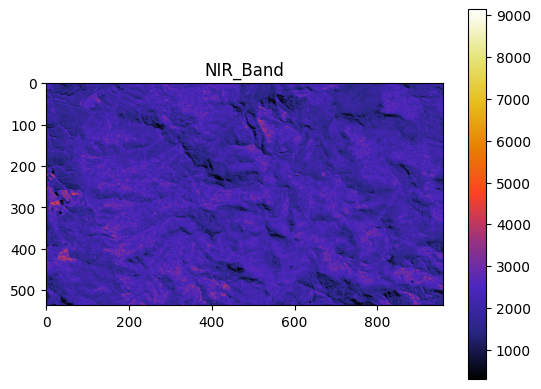

In [4]:
plt.imshow(nir, cmap='CMRmap')
plt.colorbar()
plt.title('NIR_Band')
plt.show()

# Measured Spectra

In [5]:
dataframe = r'C:\Users\BSibiya\Desktop\Leaf-Area-Index\LAI-DATASET.xlsx'
df = pd.read_excel(dataframe)

In [6]:
S2_meas = df[['B2', 'B3', 'B4', 'B5','B6', 'B7', 'B8','B8A', 'B11','B12']]

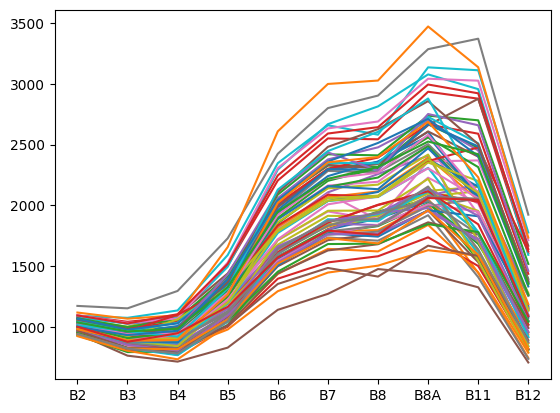

In [7]:
plt.plot(S2_meas.T);

# First a function for better control of the PROSPECT call

In [42]:
np.random.seed(0)
krange=1000
n=1.5+rand(krange)*1.9
chloro= 20+rand(krange)*39
caroten=rand(krange)*20
brown=rand(krange)*1
EWT=0.01+rand(krange)*0.02
LMA=0.012+rand(krange)*0.05
#LAI=1+rand(krange)*5

In [53]:
rho = np.zeros((krange,2101))
for i in range(krange):
    lam, rho[i,:], tau = prosail.run_prospect(n[i], chloro[i], caroten[i], brown[i], EWT[i], LMA[i], prospect_version='5')
    

In [50]:
rho

array([[0.04100662, 0.04104783, 0.04107631, ..., 0.02629099, 0.02611716,
        0.02625728],
       [0.04141237, 0.04151618, 0.04161444, ..., 0.02578031, 0.02561833,
        0.02570594],
       [0.04138488, 0.04143422, 0.04146922, ..., 0.04701105, 0.04664562,
        0.04680208],
       ...,
       [0.04120331, 0.04127169, 0.04132832, ..., 0.02966422, 0.02944033,
        0.02969181],
       [0.04099184, 0.04103083, 0.04105686, ..., 0.01787899, 0.01783447,
        0.01789551],
       [0.04106448, 0.04111261, 0.04114842, ..., 0.01974174, 0.01966742,
        0.01970932]])

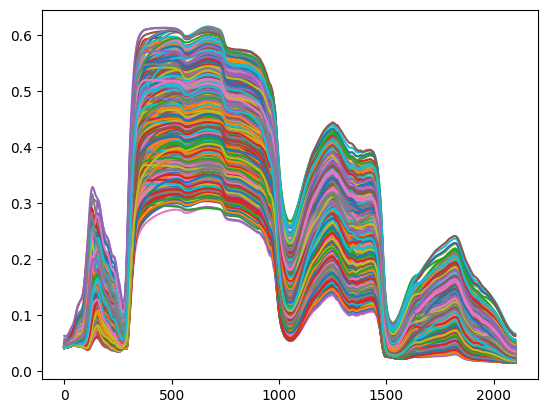

In [44]:
plt.plot(rho.T);

### Then a function to convert the input hyperspectral data to Sentinel 2A data using a weighted mean approach

In [45]:
#this function also transforms the hyperspectral data to sentinel data
def Prosail2S2(path2csv, spectra_input):
    #importing pandas
    import pandas as pd
    import numpy
    import numpy as np
    
    s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec
    s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
    spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
    rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
    w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

    output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

    return output[1:] #removes the first value because it represents the wavelength column

#please LOAD THTE FILE NOW
filepath="/Users/BSibiya/Desktop/Sandberg Fynbos Reserve/S2_response.csv"

In [46]:
tr_rho_s = np.zeros((1000, 10))
for i in range(1000):
    tr_rho_s[i, :] = Prosail2S2(filepath,  rho_out[i,0:2101].T)[np.array((1,2,3,4,5,6,7,8,11,12))]
print(tr_rho_s.shape)

S2_sim = pd.DataFrame(tr_rho_s, columns = ('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'))


(1000, 10)


In [49]:
S2_sim

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


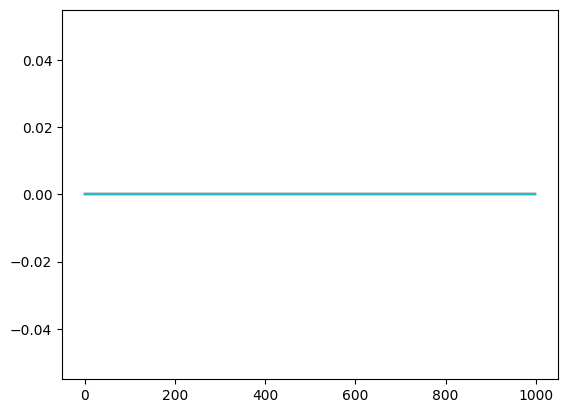

In [48]:
plt.plot(S2_sim.T);